# Recruit Restaurant Visitor Forecasting
## Team Members : 
* Apoorv Panse
* Deepti Chawda
* Shahbaz Khan

# Project Overview

Recruit Holdings has unique access to key datasets that could make automated future customer predictions possible. Specifically, Recruit Holdings owns Hot Pepper Gourmet (a restaurant review service), AirREGI (a restaurant point of sales service), and Restaurant Board (reservation log management software).

* This project aims to to use reservation and visitation data to predict the total number of visitors to a restaurant for future dates. This information will help restaurants be much more efficient and allow them to focus on creating an enjoyable dining experience for their customers.
* The datasets contain daily and hourly observations. This makes it a __Time Series Forecasting problem.__

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 50)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
sns.set(color_codes=True)

# Air Reserve CSV Analysis

__air_reserve__

Column Name | Column Description
-------------|:------------------
air_store_id | restaurant id in the air system
visit_datetime| time of the reservation
reserve_datetime | time the reservation was made
reserve_visitors | number of visitors for that reservation

In [3]:
air_reserve = pd.read_csv('air_reserve.csv')

In [4]:
air_reserve.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92378 entries, 0 to 92377
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   air_store_id      92378 non-null  object
 1   visit_datetime    92378 non-null  object
 2   reserve_datetime  92378 non-null  object
 3   reserve_visitors  92378 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 2.8+ MB


* We have total 92378 rows in the table with 4 columns. 
* Visit Dates and Reserve Dates are currently object data types, which needs to be converted to __data time format__. 

In [5]:
#Reimporting the air_reserve csv using pandas inbuilt date time format parsing.
air_reserve = air_reserve = pd.read_csv('air_reserve.csv',parse_dates=['visit_datetime', 'reserve_datetime'])

In [6]:
air_reserve.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


In [7]:
air_reserve.tail()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
92373,air_db4b38ebe7a7ceff,2017-05-29 18:00:00,2017-04-17 19:00:00,6
92374,air_1033310359ceeac1,2017-05-30 23:00:00,2017-04-19 17:00:00,8
92375,air_877f79706adbfb06,2017-05-31 20:00:00,2017-04-12 23:00:00,3
92376,air_900d755ebd2f7bbd,2017-05-31 20:00:00,2017-04-19 16:00:00,10
92377,air_3cad29d1a23209d2,2017-05-31 21:00:00,2017-04-22 10:00:00,3


In [8]:
air_reserve.describe()

,reserve_visitors
count,92378.00
mean,4.48
std,4.92
min,1.00
25%,2.00
50%,3.00
75%,5.00
max,100.00


* We have atleast 1 visitor for all rows. 
* Maximum visitors count is much higher than the mean visitors count. 
* We have data from 2016-01-01 19:00:00 and end date is 2017-05-31 21:00:00

In [9]:
air_reserve.visit_datetime.is_monotonic

True

The rows are __sorted by visit date__ time column.

In [10]:
air_reserve.isnull().values.any()

False

There are __no null__ values in the table 

In [11]:
print('Number of unique restaurants in the air_reserve table : ', len(air_reserve['air_store_id'].unique()))

Number of unique restaurants in the air_reserve table :  314


In [12]:
air_reserve["visit_year"] = pd.DatetimeIndex(air_reserve['visit_datetime']).year
air_reserve["visit_month"] = pd.DatetimeIndex(air_reserve['visit_datetime']).month
air_reserve["visit_weekday"] = pd.DatetimeIndex(air_reserve['visit_datetime']).weekday
air_reserve["visit_date"] = pd.DatetimeIndex(air_reserve['visit_datetime']).date
air_reserve.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_year,visit_month,visit_weekday,visit_date
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,2016,1,4,2016-01-01
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3,2016,1,4,2016-01-01
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6,2016,1,4,2016-01-01
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,2016,1,4,2016-01-01
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5,2016,1,4,2016-01-01


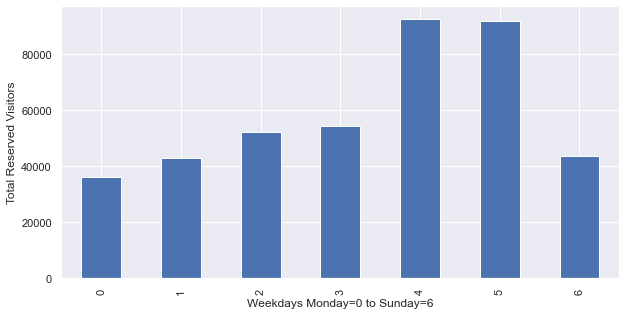

In [13]:
temp = air_reserve.groupby('visit_weekday')['reserve_visitors'].sum()
temp.plot(kind='bar',xlabel = "Weekdays Monday=0 to Sunday=6",ylabel="Total Reserved Visitors",figsize=(10,5))
plt.show()

* There are usually more number of visitors on Fridays and Saturdays

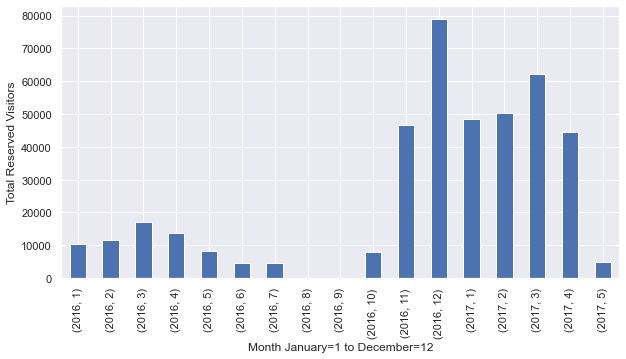

In [14]:
temp = air_reserve.groupby(['visit_year','visit_month'])['reserve_visitors'].sum()
temp.plot(kind='bar',xlabel = "Month January=1 to December=12",ylabel="Total Reserved Visitors",figsize=(10,5))
plt.show()

* There is a certain jump in total visits after November 2016
* Missing values in Dates.

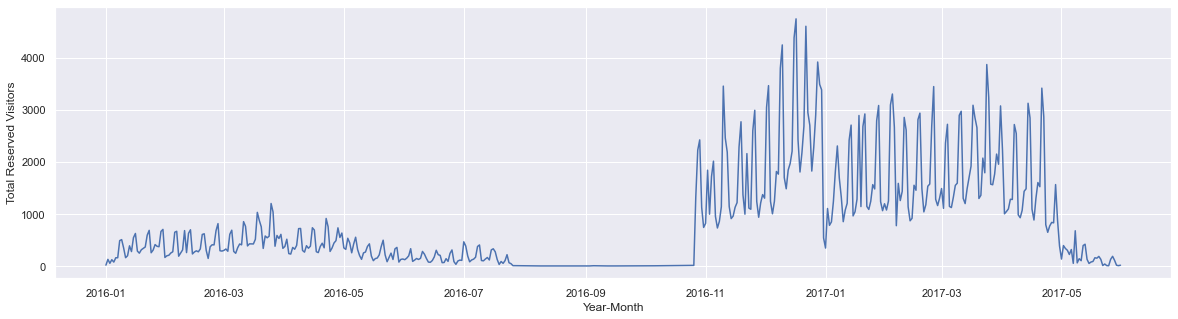

In [15]:
temp = air_reserve.groupby('visit_date')['reserve_visitors'].sum()
temp.plot(kind='line',xlabel="Year-Month",ylabel="Total Reserved Visitors",figsize=(20,5))
plt.show()

* There is an unusual dip during 2017-01

# Air Store Info CSV Analysis

__air_store_info.csv__

Column Name | Column Description
-------------|:------------------
air_store_id | restaurant id in the air system
air_genre_name | genre in the air system
air_area_name | area of the restaurant in the air system
latitude | latitude
longitude | longitude

In [16]:
air_store_info = pd.read_csv('air_store_info.csv')

In [17]:
air_store_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   air_store_id    829 non-null    object 
 1   air_genre_name  829 non-null    object 
 2   air_area_name   829 non-null    object 
 3   latitude        829 non-null    float64
 4   longitude       829 non-null    float64
dtypes: float64(2), object(3)
memory usage: 32.5+ KB


In [18]:
air_store_info

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.70,135.20
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.70,135.20
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.70,135.20
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.70,135.20
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.66,139.75
...,...,...,...,...,...
824,air_9bf595ef095572fb,International cuisine,Tōkyō-to Shibuya-ku Shibuya,35.66,139.70
825,air_764f71040a413d4d,Asian,Tōkyō-to Shibuya-ku Shibuya,35.66,139.70
826,air_10bbe8acd943d8f6,Asian,Tōkyō-to Shibuya-ku Shibuya,35.66,139.70
827,air_7514d90009613cd6,Karaoke/Party,Hokkaidō Sapporo-shi Minami 3 Jōnishi,43.06,141.34


In [19]:
air_store_info.isnull().values.any()

False

In [20]:
air_store_info['air_store_id'].duplicated().any()

False

In [21]:
print('Number of unique restaurants in the air_store_info table : ', len(air_store_info['air_store_id'].unique()))

Number of unique restaurants in the air_store_info table :  829


* air_store_info file has __no null__ values, data is __clean__ and all air_store_id are __unique__

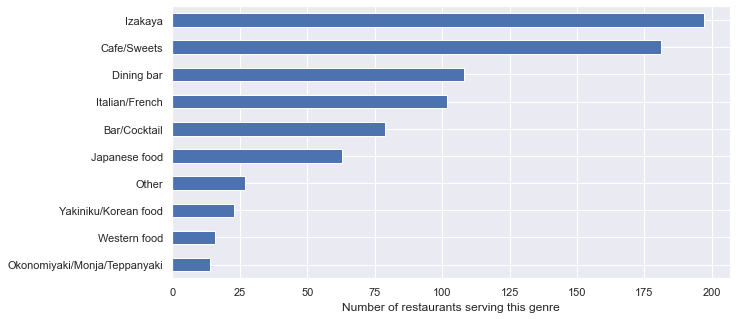

In [22]:
temp = air_store_info['air_genre_name'].value_counts()
temp.nlargest(10).sort_values().plot(kind='barh',figsize=(10,5))
plt.xlabel("Number of restaurants serving this genre")
plt.show()

* Above is the ordering of top 10 __popular food genres__

In [23]:
air_store_info.air_area_name.value_counts()

Fukuoka-ken Fukuoka-shi Daimyō              64
Tōkyō-to Shibuya-ku Shibuya                 58
Tōkyō-to Minato-ku Shibakōen                51
Tōkyō-to Shinjuku-ku Kabukichō              39
Tōkyō-to Setagaya-ku Setagaya               30
                                            ..
Hokkaidō Abashiri-shi Minami 6 Jōhigashi     2
Tōkyō-to Musashino-shi Midorichō             2
Tōkyō-to Toshima-ku Mejiro                   2
Tōkyō-to Kōtō-ku Kameido                     2
Tōkyō-to Shibuya-ku Jingūmae                 2
Name: air_area_name, Length: 103, dtype: int64

In [24]:
air_store_info['city'] = air_store_info['air_area_name'].str.split().str[0]
air_store_info['ward'] = air_store_info['air_area_name'].str.split().str[1]
air_store_info['neighborhood'] = air_store_info['air_area_name'].str.split().str[2]
air_store_info.head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude,city,ward,neighborhood
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.70,135.20,Hyōgo-ken,Kōbe-shi,Kumoidōri
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.70,135.20,Hyōgo-ken,Kōbe-shi,Kumoidōri
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.70,135.20,Hyōgo-ken,Kōbe-shi,Kumoidōri
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.70,135.20,Hyōgo-ken,Kōbe-shi,Kumoidōri
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.66,139.75,Tōkyō-to,Minato-ku,Shibakōen


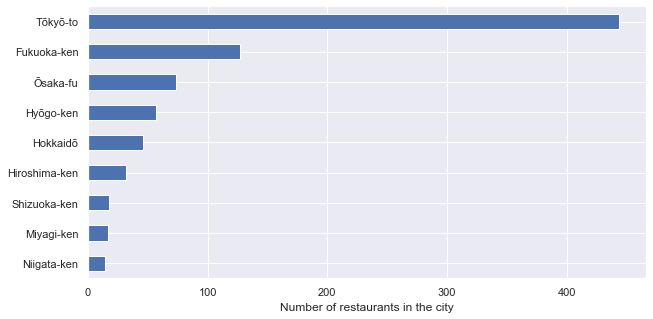

In [25]:
temp = air_store_info['city'].value_counts()
temp.sort_values().plot(kind='barh',figsize=(10,5))
plt.xlabel("Number of restaurants in the city")
plt.show()

* City with most number of restaurants is Tokyo, Fukuoka, Osaka

# Date Info CSV Analysis

__date_info.csv__

Column Name | Column Description
-------------|:------------------
calendar_date | date
day_of_week | day of the week
holiday_flg | if the day is a holiday in Japan

In [26]:
date_info = pd.read_csv('date_info.csv')

In [27]:
date_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   calendar_date  517 non-null    object
 1   day_of_week    517 non-null    object
 2   holiday_flg    517 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 12.2+ KB


In [28]:
date_info.calendar_date = pd.to_datetime(date_info.calendar_date)

In [29]:
date_info.head()

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


In [30]:
date_info.holiday_flg.value_counts()

0    482
1     35
Name: holiday_flg, dtype: int64

* It is not yet clear if __holiday flag__ means restaurants are closed that day, or if restaurants are open and chances are there would be more crowd on holidays
* There are __35 Holidays__ in the span of our timeseries

In [31]:
date_info.isnull().values.any()

False

* There are __no null values__ in the table.

# HPG Reserve CSV Analysis

__hpg_reserve.csv__

Column Name | Column Description
-------------|:------------------
hpg_store_id | restaurant id in the hpg system
visit_datetime| time of the reservation
reserve_datetime | time the reservation was made
reserve_visitors | number of visitors for that reservation

In [32]:
hpg_reserve = pd.read_csv('hpg_reserve.csv')

In [33]:
hpg_reserve.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000320 entries, 0 to 2000319
Data columns (total 4 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   hpg_store_id      object
 1   visit_datetime    object
 2   reserve_datetime  object
 3   reserve_visitors  int64 
dtypes: int64(1), object(3)
memory usage: 61.0+ MB


* We have total __2000320__ rows in the table with 4 columns. 
* Visit Dates and Reserve Dates are currently object data types, which needs to be converted to __data time format__. 

In [34]:
#Reimporting the hpg_reserve csv using pandas inbuilt date time format parsing.
hpg_reserve = hpg_reserve = pd.read_csv('hpg_reserve.csv',parse_dates=['visit_datetime', 'reserve_datetime'])

In [35]:
hpg_reserve

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13
...,...,...,...,...
2000315,hpg_2b293477ea4642fb,2017-05-31 20:00:00,2017-04-19 07:00:00,2
2000316,hpg_f922aeca48ca5a29,2017-05-31 20:00:00,2017-03-19 00:00:00,3
2000317,hpg_e9151de687b93aa3,2017-05-31 21:00:00,2017-04-14 20:00:00,49
2000318,hpg_fae6c96189b4a122,2017-05-31 21:00:00,2017-04-19 17:00:00,9


In [36]:
hpg_reserve.visit_datetime.is_monotonic

True

In [37]:
hpg_reserve.describe()

,reserve_visitors
count,2000320.00
mean,5.07
std,5.42
min,1.00
25%,2.00
50%,3.00
75%,6.00
max,100.00


* We have atleast 1 reserved visitor for all rows. 
* Maximum visitors count is much higher than the mean visitors count. 
* We have data from 2016-01-01 11:00:00 to 2017-05-31 23:00:00

In [38]:
print('Number of unique restaurants in the hpg_reserve table : ', len(hpg_reserve['hpg_store_id'].unique()))

Number of unique restaurants in the hpg_reserve table :  13325


In [39]:
hpg_reserve["visit_year"] = pd.DatetimeIndex(hpg_reserve['visit_datetime']).year
hpg_reserve["visit_month"] = pd.DatetimeIndex(hpg_reserve['visit_datetime']).month
hpg_reserve["visit_weekday"] = pd.DatetimeIndex(hpg_reserve['visit_datetime']).weekday
hpg_reserve["visit_date"] = pd.DatetimeIndex(hpg_reserve['visit_datetime']).date
hpg_reserve.head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_year,visit_month,visit_weekday,visit_date
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1,2016,1,4,2016-01-01
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3,2016,1,4,2016-01-01
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2,2016,1,4,2016-01-01
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5,2016,1,4,2016-01-01
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13,2016,1,4,2016-01-01


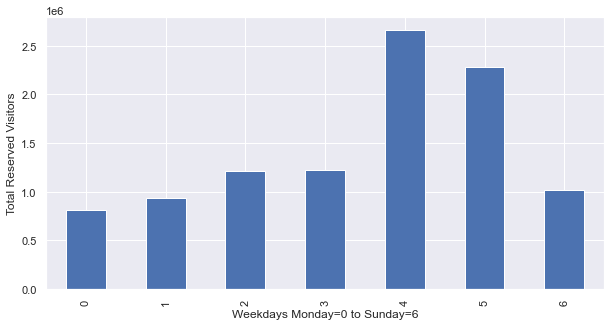

In [40]:
temp = hpg_reserve.groupby('visit_weekday')['reserve_visitors'].sum()
temp.plot(kind='bar',xlabel = "Weekdays Monday=0 to Sunday=6",ylabel="Total Reserved Visitors",figsize=(10,5))
plt.show()

* Similar to AIR Reserve, Friday saturdays haved higher number of reserved visitors in HPG data as well.

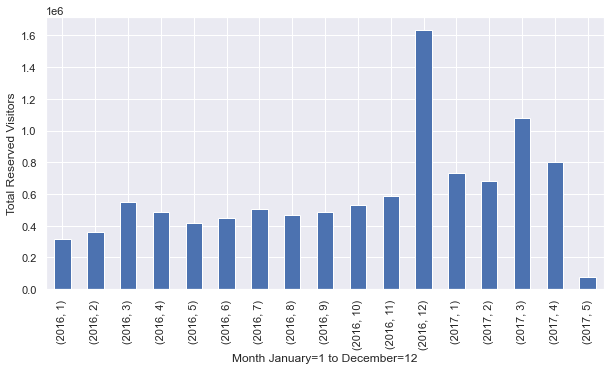

In [41]:
temp = hpg_reserve.groupby(['visit_year','visit_month'])['reserve_visitors'].sum()
temp.plot(kind='bar',xlabel = "Month January=1 to December=12",ylabel="Total Reserved Visitors",figsize=(10,5))
plt.show()

* Unlike AIR reserve data, here we can see some consistent data till November 2016 and then there is sudden jump after that.

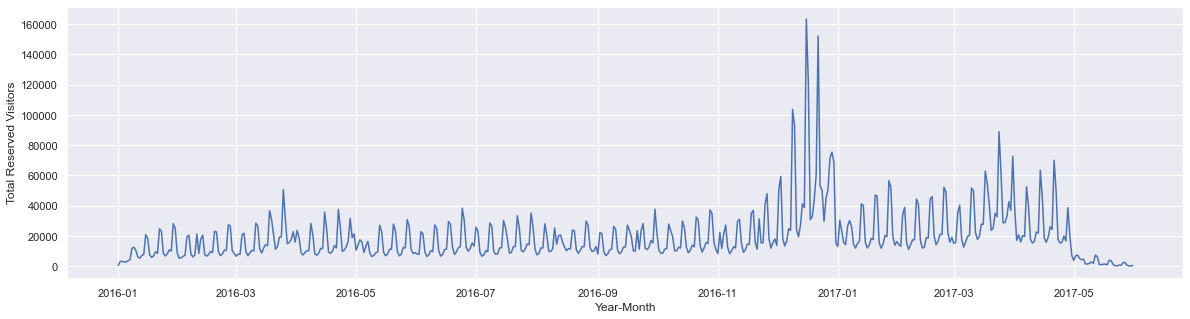

In [42]:
temp = hpg_reserve.groupby('visit_date')['reserve_visitors'].sum()
temp.plot(kind='line',xlabel="Year-Month",ylabel="Total Reserved Visitors",figsize=(20,5))
plt.show()

* Similar to AIR Data, there is sudden increase in total number of reserved visitor at the end of year 2016.

# HPG Store Info

__hpg_store_info.csv__

Column Name | Column Description
-------------|:------------------
hpg_store_id | restaurant id in the hpg system
hpg_genre_name | genre in the hpg system
hpg_area_name | area of the restaurant in the hpg system
latitude | latitude
longitude | longitude


In [43]:
hpg_store_info = pd.read_csv('hpg_store_info.csv')

In [44]:
hpg_store_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4690 entries, 0 to 4689
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   hpg_store_id    4690 non-null   object 
 1   hpg_genre_name  4690 non-null   object 
 2   hpg_area_name   4690 non-null   object 
 3   latitude        4690 non-null   float64
 4   longitude       4690 non-null   float64
dtypes: float64(2), object(3)
memory usage: 183.3+ KB


In [45]:
hpg_store_info

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.64,139.67
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.64,139.67
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.64,139.67
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.64,139.67
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.64,139.67
...,...,...,...,...,...
4685,hpg_c6ed353a48c7c93e,Sichuan food,Tōkyō-to Chiyoda-ku None,35.70,139.77
4686,hpg_a58d2423360b2fb4,Sichuan food,Tōkyō-to Minato-ku Roppongi,35.67,139.73
4687,hpg_d2021704076cdd70,Shanghai food,Tōkyō-to Chiyoda-ku None,35.70,139.77
4688,hpg_602472570d65e219,Spain/Mediterranean cuisine,Tōkyō-to Toshima-ku None,35.73,139.71


In [46]:
hpg_store_info.isnull().values.any()

False

In [47]:
hpg_store_info['hpg_store_id'].duplicated().any()

False

In [48]:
print('Number of unique restaurants in the hpg_store_info table : ', len(hpg_store_info['hpg_store_id'].unique()))

Number of unique restaurants in the hpg_store_info table :  4690


* hpg_store_info file has __no null__ values, data is __clean__ and all hpg_store_id are __unique__

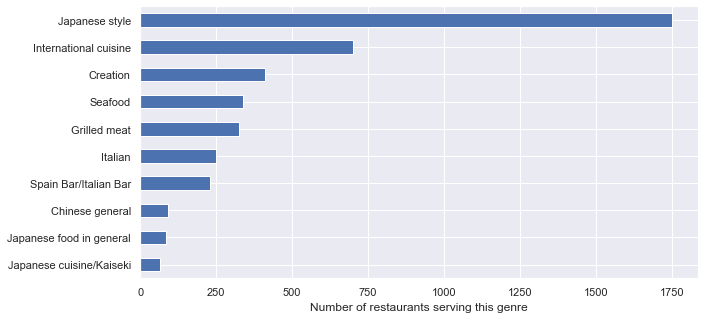

In [49]:
temp = hpg_store_info['hpg_genre_name'].value_counts()
temp.nlargest(10).sort_values().plot(kind='barh',figsize=(10,5))
plt.xlabel("Number of restaurants serving this genre")
plt.show()

* Above is the ordering of top 10 __popular food genres__

In [50]:
hpg_store_info.hpg_area_name.value_counts()

Tōkyō-to Shinjuku-ku None              257
Tōkyō-to Chūō-ku Ginza                 198
Hyōgo-ken Kōbe-shi None                163
Ōsaka-fu Ōsaka-shi Shinsaibashisuji    150
Osaka Prefecture Osaka None            145
                                      ... 
Niigata-ken Niigata-shi Kurumaba         2
Niigata-ken Nagaoka-shi Rokusho          1
Ōsaka-fu Minoo-shi Hanjo                 1
Tōkyō-to Shinagawa-ku Koyama             1
Hokkaidō Ashibetsu-shi None              1
Name: hpg_area_name, Length: 119, dtype: int64

In [51]:
hpg_store_info['city'] = hpg_store_info['hpg_area_name'].str.split().str[0]
hpg_store_info['ward'] = hpg_store_info['hpg_area_name'].str.split().str[1]
hpg_store_info['neighborhood'] = hpg_store_info['hpg_area_name'].str.split().str[2]
hpg_store_info.head()

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude,city,ward,neighborhood
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.64,139.67,Tōkyō-to,Setagaya-ku,Taishidō
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.64,139.67,Tōkyō-to,Setagaya-ku,Taishidō
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.64,139.67,Tōkyō-to,Setagaya-ku,Taishidō
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.64,139.67,Tōkyō-to,Setagaya-ku,Taishidō
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.64,139.67,Tōkyō-to,Setagaya-ku,Taishidō


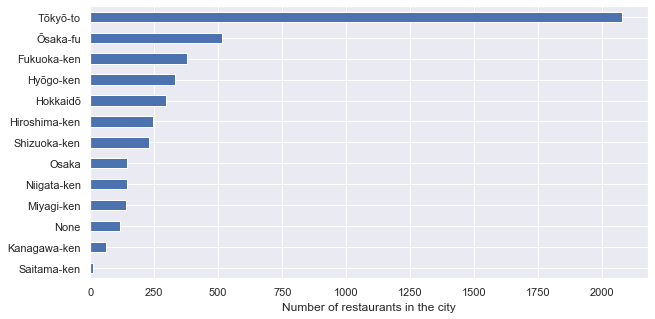

In [52]:
temp = hpg_store_info['city'].value_counts()
temp.sort_values().plot(kind='barh',figsize=(10,5))
plt.xlabel("Number of restaurants in the city")
plt.show()

* City with most number of restaurants is Tokyo, Fukuoka, Osaka

# Store ID Relation

__store_id_relation.csv__

Column Name | Column Description
-------------|:------------------
air_store_id | restaurant id in the air system
hpg_store_id | restaurant id in the hpg system

In [53]:
store_id_relation = pd.read_csv('store_id_relation.csv')
store_id_relation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   air_store_id  150 non-null    object
 1   hpg_store_id  150 non-null    object
dtypes: object(2)
memory usage: 2.5+ KB


In [54]:
store_id_relation

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7
...,...,...
145,air_b8925441167c3152,hpg_0cc0abae3a8b52de
146,air_f8233ad00755c35c,hpg_098e4dd30e54fee6
147,air_6607fe3671242ce3,hpg_1004356dc8ab69ec
148,air_ccd19a5bc5573ae5,hpg_df22bf146d2c7e19


* Store ID relation table contains mapping of restaurant names in AIR and HPG system
* Point to be noted here is, that this relation has only 150 entries. And number of AIR / HPG restaurants are much more than that. So we'll have to be careful while merging these two. 

In [55]:
store_id_relation.isnull().values.any()

False

In [56]:
print('Number of unique air_store_id in table : ', len(store_id_relation['air_store_id'].unique()))
print('Number of unique hpg_store_id in table : ', len(store_id_relation['hpg_store_id'].unique()))

Number of unique air_store_id in table :  150
Number of unique hpg_store_id in table :  150


* Just to verify if there are no inconsistent mappings.

# Train CSV

__train.csv__

Column Name | Column Description
-------------|:------------------
air_store_id | restaurant id in the air system
visit_date | date
visitors | the number of visitors to the restaurant on the date

In [57]:
train = pd.read_csv('train.csv')

In [58]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239673 entries, 0 to 239672
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   air_store_id  239673 non-null  object
 1   visit_date    239673 non-null  object
 2   visitors      239673 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 5.5+ MB


In [59]:
train = pd.read_csv('train.csv',parse_dates=['visit_date'])

In [60]:
train.head()

,air_store_id,visit_date,visitors
0,air_e3020992d5fe5dfd,2016-07-01,21
1,air_e3020992d5fe5dfd,2016-07-02,19
2,air_e3020992d5fe5dfd,2016-07-04,8
3,air_e3020992d5fe5dfd,2016-07-05,11
4,air_e3020992d5fe5dfd,2016-07-06,16


In [61]:
print('Number of unique restaurants in the training data : ', len(train['air_store_id'].unique()))

Number of unique restaurants in the training data :  829


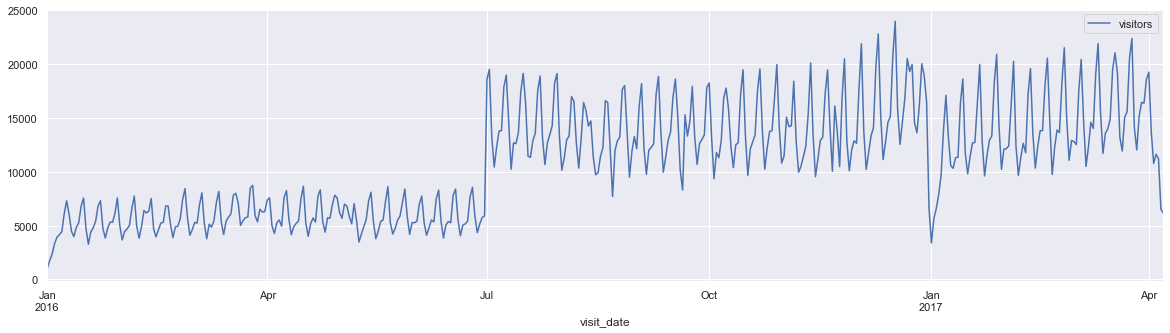

In [62]:
train.groupby('visit_date').sum().plot(figsize=(20,5))
plt.show()

In [63]:
train.isnull().values.any()

False

* There are no null values in training data

In [64]:
pd.Series(list(set(train.air_store_id).intersection(set(store_id_relation.air_store_id))))

0      air_28064154614b2e6c
1      air_6b15edd1b4fbb96a
2      air_3e93f3c81008696d
3      air_08cb3c4ee6cd6a22
4      air_831658500aa7c846
               ...         
145    air_cb7467aed805e7fe
146    air_8f3b563416efc6ad
147    air_638c35eb25e53eea
148    air_c759b6abeb552160
149    air_5d7c744c3a2ef624
Length: 150, dtype: object

In [65]:
pd.Series(list(set(air_store_info.air_store_id).intersection(set(store_id_relation.air_store_id))))

0      air_28064154614b2e6c
1      air_6b15edd1b4fbb96a
2      air_3e93f3c81008696d
3      air_08cb3c4ee6cd6a22
4      air_831658500aa7c846
               ...         
145    air_cb7467aed805e7fe
146    air_8f3b563416efc6ad
147    air_638c35eb25e53eea
148    air_c759b6abeb552160
149    air_5d7c744c3a2ef624
Length: 150, dtype: object

In [66]:
pd.Series(list(set(air_store_info.air_store_id).intersection(set(train.air_store_id))))

0      air_e483f5b3c4f310e0
1      air_6ca1d941c8199a67
2      air_04341b588bde96cd
3      air_3c05c8f26c611eb9
4      air_74cf22153214064c
               ...         
824    air_63a88d81295195ed
825    air_f927b2da69a82341
826    air_2a184c1745274b2b
827    air_d3e7b5952cd09ccb
828    air_2ac361b97630e2df
Length: 829, dtype: object

* As our training data contains all the air_store_id that are present in store_id_relation, we would need to merge all hpg data from hpg_reserve corresponding to these air_store_id in air_reserve data.

# Sample Submission CSV

In [67]:
sample_submission = pd.read_csv('sample_submission.csv')

In [68]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12435 entries, 0 to 12434
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        12435 non-null  object
 1   visitors  12435 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 194.4+ KB


In [69]:
sample_submission

,id,visitors
0,air_e3020992d5fe5dfd_2017-04-06,0
1,air_e3020992d5fe5dfd_2017-04-07,0
2,air_e3020992d5fe5dfd_2017-04-08,0
3,air_e3020992d5fe5dfd_2017-04-10,0
4,air_e3020992d5fe5dfd_2017-04-11,0
...,...,...
12430,air_4ce7b17062a1bf73_2017-04-18,0
12431,air_4ce7b17062a1bf73_2017-04-19,0
12432,air_4ce7b17062a1bf73_2017-04-20,0
12433,air_4ce7b17062a1bf73_2017-04-21,0


In [70]:
#Extracting air store id from sample submission and checking if all id are present in our training data set.
pd.DataFrame(sample_submission.id.str.rsplit('_',1))['id'].str[0].isin(train.air_store_id).all()

True

* All the air store id present in Sample Submission csv are present in Training data
* This means we have data to predict visitors for every restaurant in sample submission and there are no missing restaurants in training set or metadata

## Next task is to merge the metadata with the training data set, and to collectively analyse the information (EDA) and identifying important features to keep for training a model

General intuition for important features that might be useful for prediction : 
* Month, weekday
* Type of cuisine genre served by restaurant (Genre)
* City / Area / Ward
* holiday flag
* Number of reservations made in advance vs number of actual visitors